In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import joblib
import csv
import warnings
warnings.filterwarnings('ignore')

# Load and clean phase

In [32]:
def load_data_frame():

    with open("transport.csv", "r", newline="") as fp:
        reader = csv.reader(fp, delimiter=";")
        df = pd.DataFrame(reader)
        df = df.drop(labels=[0,1], axis=0)
        for i in range(11):
            df = df.drop(labels=[316 + i], axis=0)
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
        df = df.drop(labels=["_Svar-ID", "Resume-Code", "Start", "Dato og tid", "Deltagerstatus"], axis=1)

        return df

In [33]:
def translate_data(df):

    old_column_names = ["1. Hvor gammel er du?", "2. Er du mand eller kvinde?", "3. Hvilken form for by bor du i?", "4. Hvad er din civil status?",
                        "5. Har du hjemmeboende børn?", "6. Har du bil?", "7. Har du en cykel?", "8. Hvilken form for transport bruger du mest når du skal rundt i egen by?",
                        "9. Hvilken form for transport bruger du mest når du skal ud for egen by?", "10. Hvor langt har du til arbejde?",
                        "11. Hvilken form for transport bruger du mest til og fra arbejde?", "12. Hvor langt har du til skole?",
                        "13. Hvilken form for transport bruger du mest til og fra skole?", "14. Har parkerings muligheder indflydelse på dit valg af transport?",
                        "15. Hvis det er en solskinsdag - vælg det udsagn der passer bedst", "16. Hvis det er en regnvejrsdag - vælg det udsagn der passer bedst"]

    new_column_names = ["Age", "Gender", "City", "Civil status", "Kids living at home", "Owns a car", "Owns a bike", "Kind of transport within own city",
                        "Kind of transport outside own city", "Distance to work", "Transport to and from work", "Distance to school", "Transport to and from school",
                        "Does parkings have an influence", "Statement on a shiny day", "Statement on a rainy day"]

    for i in range(len(new_column_names)):
        df = df.rename(columns={old_column_names[i]:new_column_names[i]})

    df['Gender'] = df['Gender'].map({'Mand': 'Male', 'Kvinde': 'Female'})
    df['City'] = df['City'].map({'Forstad': 'Suburb', 'Storby': 'Big city', 'Landet': 'Country'})
    df['Civil status'] = df['Civil status'].map({'Single': 'Single', 'I forhold': 'In relationship', 'Ved ikke': 'Dont know'})
    df['Kids living at home'] = df['Kids living at home'].map({'ja': 'yes', 'nej': 'no'})
    df['Owns a car'] = df['Owns a car'].map({'ja': 'yes', 'nej': 'no'})
    df['Owns a bike'] = df['Owns a bike'].map({'ja': 'yes', 'nej': 'no'})
    df['Kind of transport within own city'] = df['Kind of transport within own city'].map({'Bil': 'Car', 'Knallert': 'Moped', 'Cykel': 'Bike', 'Tog': 'Train',
                                                                                           'Bus': 'Bus', 'Jeg går/løber': 'I walk/run', 'Andet': 'Other'})
    df['Kind of transport outside own city'] = df['Kind of transport outside own city'].map({'Bil': 'Car', 'Knallert': 'Moped', 'Cykel': 'Bike', 'Tog': 'Train',
                                                                                           'Bus': 'Bus', 'Jeg går/løber': 'I walk/run', 'Andet': 'Other'})
    df['Distance to work'] = df['Distance to work'].map({'Under 1 km': 'Under 1 km', 'Mellem 1-5 km': 'Between 1-5 km', 'Mellem 5-15 km': 'Between 5-15 km',
                                                         'Mellem 15-25 km': 'Between 15-25 km', 'Mellem 25-40 km': 'Between 25-40 km', 'Over 40 km': 'Over 40 km',
                                                         'Jeg arbejdeder kun hjemmefra': 'I only work from home', 'Jeg har ikke noget arbejde': 'I dont have a job'})
    df['Transport to and from work'] = df['Transport to and from work'].map({'Bil': 'Car', 'Knallert': 'Moped', 'Cykel': 'Bike', 'Tog': 'Train',
                                                                                           'Bus': 'Bus', 'Jeg går/løber': 'I walk/run', 'Jeg har ikke noget arbejde':
                                                                                 'I dont have a job', 'Andet': 'Other'})
    df['Distance to school'] = df['Distance to school'].map({'Under 1 km': 'Under 1 km', 'Mellem 1-5 km': 'Between 1-5 km', 'Mellem 5-15 km': 'Between 5-15 km',
                                                         'Mellem 15-25 km': 'Between 15-25 km', 'Mellem 25-40 km': 'Between 25-40 km', 'Over 40 km': 'Over 40 km',
                                                        'Jeg går ikke i skole': 'I dont go to school'})
    df['Transport to and from school'] = df['Transport to and from school'].map({'Bil': 'Car', 'Knallert': 'Moped', 'Cykel': 'Bike', 'Tog': 'Train',
                                                                                           'Bus': 'Bus', 'Jeg går/løber': 'I walk/run', 'Jeg går ikke i skole':
                                                                                 'I dont go to school', 'Andet': 'Other'})
    df['Does parkings have an influence'] = df['Does parkings have an influence'].map({'Ja': 'yes', 'Nej': 'no', 'Ved ikke': 'Dont know'})

    df['Statement on a shiny day'] = df['Statement on a shiny day'].map({'Jeg går eller cykler altid hvis afstanden passer til det': 'Walk/bike alwas if the weather fits',
                                                                         'Jeg går eller cykler en gang imellem hvis afstanden passer til det': 'Walk/bike sometimes if the weather fits',
                                                                         'Jeg går eller cykler sjældent også selvom afstanden passer til det': 'Walk/bike rarely even if the weather fits',
                                                                         'Jeg tager stort set altid tog, bus eller bil': 'Always train, bus or car',
                                                                         'Ved ikke': 'Dont know'})
    df['Statement on a rainy day'] = df['Statement on a rainy day'].map({'Jeg går eller cykler altid hvis afstanden passer til det': 'Walk/bike alwas if the weather fits',
                                                                         'Jeg går eller cykler en gang imellem hvis afstanden passer til det': 'Walk/bike sometimes if the weather fits',
                                                                         'Jeg går eller cykler sjældent også selvom afstanden passer til det': 'Walk/bike rarely even if the weather fits',
                                                                         'Jeg tager stort set altid tog, bus eller bil': 'Always train, bus or car',
                                                                         'Ved ikke': 'Dont know'})
    
    return df

# Basic analysis

In [34]:
def calculate_chart(df, y_value, x_value, result_value, chart):
    
    df_1 = df[[x_value]]
    df_1["all"] = 1
    df_1 = df_1.groupby([x_value], as_index=False)["all"].count()

    df_2 = df[[x_value, y_value]]
    df_2["counter"] = 1
    df_2 = df_2.groupby([x_value, y_value], as_index=False)["counter"].count()

    df_3 = df_2.loc[df_2[y_value] == result_value]
    df_3 = pd.merge(df_3, df_1, left_on=x_value, right_on=x_value, how='inner')
    df_3["percent"] = df_3['counter'] * 100 / df_3["all"]
    
    plt.ylabel("Percent %")
    plt.xlabel(x_value)
    plt.xticks(rotation=45)
    plt.title("This is the how many travel by " + result_value + ", measured in percent")
    
    if chart == "plot":
        return df_3, plt.plot(df_3[x_value], df_3["percent"])
    elif chart == "bar":
        return df_3, plt.bar(df_3[x_value], df_3["percent"])
    elif chart == "scatter":
        return df_3, plt.scatter(df_3[x_value], df_3["percent"])


In [35]:

df = load_data_frame()
df = translate_data(df)
#pd.set_option('max_row', None)
df

2,Age,Gender,City,Civil status,Kids living at home,Owns a car,Owns a bike,Kind of transport within own city,Kind of transport outside own city,Distance to work,Transport to and from work,Distance to school,Transport to and from school,Does parkings have an influence,Statement on a shiny day,Statement on a rainy day,
3,15 - 25,Male,Big city,Single,no,no,yes,Bike,Train,Between 1-5 km,Bike,Under 1 km,I walk/run,no,Walk/bike alwas if the weather fits,Walk/bike sometimes if the weather fits,
4,Over 60,Male,Suburb,In relationship,no,yes,yes,Car,Car,Between 5-15 km,Car,I dont go to school,I dont go to school,yes,Walk/bike sometimes if the weather fits,"Always train, bus or car",
5,36 - 45,Female,Big city,Single,no,no,yes,Bike,Train,Under 1 km,Bike,I dont go to school,I dont go to school,no,Walk/bike alwas if the weather fits,"Always train, bus or car",
6,36 - 45,Female,Suburb,In relationship,yes,yes,yes,Car,Car,Over 40 km,Car,Between 1-5 km,Car,yes,NaN,"Always train, bus or car",
7,26 - 35,Female,Big city,In relationship,no,yes,yes,Train,Car,Between 5-15 km,Train,I dont go to school,I dont go to school,yes,Walk/bike alwas if the weather fits,Walk/bike rarely even if the weather fits,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,Over 60,Male,Suburb,In relationship,no,yes,yes,Car,Car,Under 1 km,I walk/run,I dont go to school,I dont go to school,yes,Walk/bike sometimes if the weather fits,"Always train, bus or car",
312,Over 60,Male,Suburb,In relationship,yes,yes,no,Car,Car,Between 5-15 km,Car,I dont go to school,I dont go to school,yes,"Always train, bus or car","Always train, bus or car",
313,Over 60,Male,Suburb,In relationship,no,yes,no,Car,Car,I only work from home,I dont have a job,I dont go to school,I dont go to school,yes,"Always train, bus or car","Always train, bus or car",
314,45 - 60,Female,Country,Single,yes,yes,yes,Car,Car,I only work from home,Other,Between 5-15 km,Car,yes,"Always train, bus or car","Always train, bus or car",


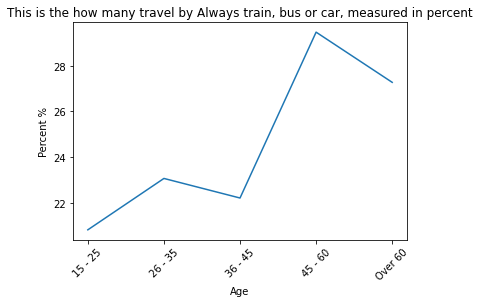

In [326]:
df_3, plot = calculate_chart(df, "Statement on a shiny day", "Age", "Always train, bus or car", "plot")

# 1. Predictive model - Classification

In [330]:

def convert_string_to_int(df, input_list, output_value):
    
    X = df[input_list]
    conditions = []
    choices = []
    
    for i in range(len(input_list)):
        column_value = df[input_list[i]].unique()
        condition = []
        choice = []
        for cv in range(len(column_value)):
            condition.append(
            (X[input_list[i]]==column_value[cv]))
            choice.append(cv +1)
        conditions.append(condition)
        choices.append(choice)
        X[input_list[i] + "_2"] = np.select(conditions[i], choices[i])
    y = df[output_value]
            
    return X, y

def predict_classification(df, prediction_input, input_list, output_value, prediction_model):
    
    X, y = convert_string_to_int(df, input_list, output_value)
    X = X.drop(columns=input_list)
    
    model = prediction_model
    model.fit(X, y)
    prediction = model.predict([prediction_input])
    
    return prediction

def classification_accuracy(df, prediction_input, input_list, output_value, prediction_model, testSize):
    
    from sklearn.metrics import accuracy_score
    
    X, y = convert_string_to_int(df, input_list, output_value)
    X = X.drop(columns=input_list)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)
    
    model = prediction_model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    score = accuracy_score(y_test, predictions)
    
    return score
    

input_list = ["City", "Civil status", "Gender", "Age", "Kids living at home", "Owns a bike"]

In [331]:
X, y = convert_string_to_int(df, input_list, "Age")
X

2,City,Civil status,Gender,Age,Kids living at home,Owns a bike,City_2,Civil status_2,Gender_2,Age_2,Kids living at home_2,Owns a bike_2
3,Big city,Single,Male,15 - 25,no,yes,1,1,1,1,1,1
4,Suburb,In relationship,Male,Over 60,no,yes,2,2,1,2,1,1
5,Big city,Single,Female,36 - 45,no,yes,1,1,2,3,1,1
6,Suburb,In relationship,Female,36 - 45,yes,yes,2,2,2,3,2,1
7,Big city,In relationship,Female,26 - 35,no,yes,1,2,2,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
311,Suburb,In relationship,Male,Over 60,no,yes,2,2,1,2,1,1
312,Suburb,In relationship,Male,Over 60,yes,no,2,2,1,2,2,2
313,Suburb,In relationship,Male,Over 60,no,no,2,2,1,2,1,2
314,Country,Single,Female,45 - 60,yes,yes,3,1,2,5,2,1


In [391]:
prediction = predict_classification(df, [1, 1, 1, 1, 1, 1], input_list, "Transport to and from work", DecisionTreeClassifier())
prediction

array(['Bike'], dtype=object)

In [392]:
forest_prediction = predict_classification(df, [1, 1, 1, 1, 1, 1], input_list, "Transport to and from work", RandomForestClassifier())
forest_prediction

array(['Bike'], dtype=object)

In [397]:
score = classification_accuracy(df, [1, 1, 1, 1, 1, 1], input_list, "Transport to and from work", RandomForestClassifier(), 0.1)
score

0.5

# Staging code

In [216]:
XX, y = convert_string_to_int(df, ["Distance to work", "Age"], "Age")
XX["All"] = 1
X = XX.drop(columns=["Distance to work", "Age_2"])

Y = X.groupby(["Age"], as_index=False)["All"].count()
X = X.groupby(["Age"], as_index=False)["Distance to work_2"].sum()

X = pd.merge(X, Y, left_on="Age", right_on="Age", how='inner')

X["Average"] = X["Distance to work_2"] / X["All"]
plt.scatter(X["Age"], X["Average"])

2,Age,Distance to work_2,All,Average
0,15 - 25,143,48,2.979167
1,26 - 35,212,52,4.076923
2,36 - 45,213,45,4.733333
3,45 - 60,601,112,5.366071
4,Over 60,247,55,4.490909
5,Under 15,1,1,1.000000


In [49]:
X = df[["City", "Civil status"]]

conditions = [
    (X["City"]=="Big city"),
    (X["City"]=="Suburb"),
    (X["City"]=="Country")]
choices = [1,2,3]
X["City_2"] = np.select(conditions, choices)

conditions_1 = [
    (X["Civil status"]=="Single"),
    (X["Civil status"]=="In relationship"),
    (X["Civil status"]=="Dont know")]
choices_1 = [1,2,3]
X["Civil status 2"] = np.select(conditions_1, choices_1)
X = X.drop(columns=["City", "Civil status"])

## CIVIL STATUS
# 1 = single
# 2 = In relationship
# 3 = Dont know


## City 
# 1 = Big City
# 2 = Suburb
# 3 = Country


y = df["Age"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

score = accuracy_score(y_test, predictions)
score

TypeError: 'numpy.float64' object is not callable

In [83]:
model.fit(X, y)
prediction_2 = model.predict([[3, 1]])
prediction_2

array(['Over 60'], dtype=object)

In [98]:
tree.export_graphviz(model, out_file='test_tree.dot',
                    feature_names=['City', 'Civil status'],
                    class_names=sorted(y.unique()),
                    label='all',
                    rounded=True,
                    filled=True)